In [62]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import simpy
import random
from datetime import datetime
from collections import deque, defaultdict
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [64]:
#Loading Dataset for MDP
df_mdp = pd.read_csv('/Users/riyasebastian/Desktop/UNI/Project/final/Call_Center_Dataset.csv')

#Converting time columns
df_mdp['DateTime'] = pd.to_datetime(df_mdp['Date'] + ' ' + df_mdp['Time'])
df_mdp['Hour'] = df_mdp['DateTime'].dt.hour

#Converting AvgTalk duration to seconds
def time_to_seconds(time_str):
    if pd.isna(time_str):
        return 0
    try:
        parts = str(time_str).split(':')
        if len(parts) == 2:
            return int(parts[0]) * 60 + int(parts[1])
        elif len(parts) == 3:
            return int(parts[0]) * 3600 + int(parts[1]) * 60 + int(parts[2])
        else:
            return 0
    except:
        return 0

df_mdp['Talk_Duration_Seconds'] =df_mdp['AvgTalkDuration'].apply(time_to_seconds)

# Creating columns to binary
df_mdp['Answered_Binary'] = (df_mdp['Answered_YN'] == 'Y').astype(int)
df_mdp['Resolved_Binary'] = (df_mdp['Resolved'] == 'Y').astype(int)


#Handlling missing values
df_mdp['Speed_of_Answer_Seconds'] = df_mdp['Speed_of_Answer_Seconds'].fillna(df_mdp['Speed_of_Answer_Seconds'].mean())
df_mdp['Satisfaction_Rating'] =df_mdp['Satisfaction_Rating'].fillna(df_mdp['Satisfaction_Rating'].mean())
df_mdp['Talk_Duration_Seconds'] =df_mdp['Talk_Duration_Seconds'].fillna(df_mdp['Talk_Duration_Seconds'].mean())
df_mdp = df_mdp.fillna(0)

print(f"Dataset shape: {df_mdp.shape}")

#Setting agent skills
agent_skills = {
    'Agent_A': [1, 2],      #Customer service, New accounts
    'Agent_B': [3],         #Technical support  
    'Agent_C': [1, 4],      #Customer service, Sales
    'Agent_D': [5, 6],      #Billing, Retention
    'Agent_E': [1, 3, 5],   #Customer service, Technical support, Billing
    'Agent_F': [2, 4, 6],   #New accounts, Sales, Retention
    'Agent_G': [3, 5],      #Technical support, Billing
    'Agent_H': [1, 2, 4, 6] #Multi skilled
}

#Skill mapping
skill_mapping = {
    'Customer_Service': 1,
    'New_Accounts': 2,
    'Technical_Support': 3,
    'Sales': 4,
    'Billing': 5,
    'Retention': 6
}

#Performance metrics calculation
skill_performance = {}
for skill, skill_id in skill_mapping.items():
    skill_data = df_mdp[df_mdp['Skill_ID'] == skill]
    if len(skill_data) > 0:
        avg_satisfaction = skill_data['Satisfaction_Rating'].mean()
        avg_speed = skill_data['Speed_of_Answer_Seconds'].mean()
        resolution_rate = skill_data['Resolved_Binary'].mean()
        
        if np.isnan(avg_satisfaction):
            avg_satisfaction = 3.0
        if np.isnan(avg_speed):
            avg_speed = 30.0
        if np.isnan(resolution_rate):
            resolution_rate = 0.8
            
        performance_score = (avg_satisfaction * 0.4) + (resolution_rate * 0.4) + (1 - min(avg_speed/60, 1)) * 0.2
        skill_performance[skill_id] = performance_score
    else:
        skill_performance[skill_id] = 0.5

#MDP parameters
max_speed = df_mdp['Speed_of_Answer_Seconds'].max()
max_wait_time = int(max_speed / 60) if not np.isnan(max_speed) else 5
max_wait_list = min(max_wait_time, 10)
gamma = 0.9

#Value function
V = {}

#Initializing value function
def initialize_value_function():
    for skill_type in range(1, 7):  # 6 skills
        for wait_time in range(max_wait_list + 1):
            V[(skill_type, wait_time)] = 0

#Reward function
def reward(state, dataset_record=None):
    skill_type, wait_time = state
    base_reward = skill_performance.get(skill_type, 0.5) * 10
    wait_penalty = wait_time * 2
    
    if dataset_record is not None:
        satisfaction_rating = dataset_record['Satisfaction_Rating']
        satisfaction_bonus = (satisfaction_rating if not pd.isna(satisfaction_rating) else 3.0) * 2
        resolution_bonus = dataset_record['Resolved_Binary'] * 5
        speed_sec = dataset_record['Speed_of_Answer_Seconds']
        if pd.isna(speed_sec):
            speed_bonus = 0
        else:
            speed_bonus = max(0, (60 - speed_sec) / 60) * 3
            
        return base_reward + satisfaction_bonus + resolution_bonus + speed_bonus - wait_penalty
    
    return base_reward - wait_penalty

#Value iteration function
def value_iteration():
    threshold = 0.01
    delta = 1
    actions = list(agent_skills.keys()) + ['wait']
    
    iteration = 0
    while delta > threshold:
        delta = 0
        for state in V:
            old_value = V[state]
            action_values = []
            
            #Evaluating all possible actions
            for action in actions:
                if action == 'wait':
                    new_state = (state[0], min(state[1] + 1, max_wait_list))
                    value = reward(state) + gamma * V[new_state]
                else:
                    agent_skills_list = agent_skills.get(action, [])
                    if state[0] in agent_skills_list:
                        new_state = (state[0], 0) 
                        value = reward(state) + gamma * V[new_state]
                    else:
                        value = reward(state) + gamma * V[state] - 10  #Penalty
                action_values.append(value)
            
            V[state] = max(action_values)
            delta = max(delta, abs(old_value - V[state]))
        
        iteration += 1
        if iteration % 20 == 0:
            print(f"Value iteration: {iteration} iterations, delta = {delta:.4f}")
    
    print(f"Value iteration completed after {iteration} iterations")

#Initializing and running value iteration
initialize_value_function()
value_iteration()

print(f"\nMDP parameters:")
print(f"  Max wait time: {max_wait_list} minutes")
print(f"  Discount factor: {gamma}")
print(f"  State space size: {len(V)} states")


Dataset shape: (1500, 19)
Value iteration: 20 iterations, delta = 1.1153
Value iteration: 40 iterations, delta = 0.1356
Value iteration: 60 iterations, delta = 0.0165
Value iteration completed after 65 iterations

MDP parameters:
  Max wait time: 1 minutes
  Discount factor: 0.9
  State space size: 12 states


In [66]:
#MDP Implementation

#Getting MDP state from dataset
def get_state_from_record(record):
    skill_type = skill_mapping[record['Skill_ID']]
    speed_sec = record['Speed_of_Answer_Seconds']
    if pd.isna(speed_sec):
        wait_time = max_wait_list 
    else:
        wait_time = min(int(speed_sec/ 60), max_wait_list)
    return (skill_type,wait_time)

#Assigning best action for each state
def get_optimal_action(state):
    skill_type, wait_time = state
    actions = list(agent_skills.keys()) + ['wait']
    
    best_action = None
    best_value = float('-inf')
    
    for action in actions:
        if action == 'wait':
            new_state = (skill_type, min(wait_time + 1, max_wait_list))
            value = reward(state) + gamma * V[new_state]
        else:
            #Assigning call to agent
            agent_skills_list = agent_skills.get(action, [])
            if skill_type in agent_skills_list:
                new_state = (skill_type, 0)
                value = reward(state) + gamma * V[new_state]
            else:
                value = reward(state) + gamma * V[state] - 10 
        
        if value > best_value:
            best_value = value
            best_action = action
    
    return best_action, best_value

#Calculating agent performance
def calculate_agent_performance(agent_id, assigned_records):
    if not assigned_records:
        return 0, 0, 0
    
    valid_satisfaction = [record['Satisfaction_Rating'] for record in assigned_records 
                         if not pd.isna(record['Satisfaction_Rating'])]
    valid_speed = [record['Speed_of_Answer_Seconds'] for record in assigned_records 
                  if not pd.isna(record['Speed_of_Answer_Seconds'])]
    
    total_satisfaction = sum(valid_satisfaction) if valid_satisfaction else 0
    total_resolution = sum(record['Resolved_Binary'] for record in assigned_records)
    total_speed = sum(valid_speed) if valid_speed else 0
    
    avg_satisfaction = total_satisfaction / len(valid_satisfaction) if valid_satisfaction else 3.0
    resolution_rate = total_resolution / len(assigned_records)
    avg_speed = total_speed / len(valid_speed) if valid_speed else 30.0
    
    return avg_satisfaction, resolution_rate, avg_speed

#Running MDP
def run_mdp_dataset_evaluation(dataset, num_episodes=100):
    
    dataset_shuffled = dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    
    mdp_rewards = []
    mdp_waiting_times = []
    mdp_satisfactions = []
    mdp_resolutions = []
    agent_assignments = defaultdict(list)
    
    episode_size = len(dataset_shuffled)//num_episodes
    
    for episode in range(num_episodes):
        episode_reward = 0
        episode_wait_times = []
        episode_satisfactions = []
        episode_resolutions = []
        
        start = episode * episode_size
        end = min((episode + 1) *episode_size, len(dataset_shuffled))
        episode_data = dataset_shuffled.iloc[start:end]
        
        for _, record in episode_data.iterrows():
            state = get_state_from_record(record)
            action, value = get_optimal_action(state)

            #Calculating reward
            record_reward = reward(state, record)
            episode_reward += record_reward
            
            #Calculating metrics
            episode_wait_times.append(record['Speed_of_Answer_Seconds']/60) 
            episode_satisfactions.append(record['Satisfaction_Rating'])
            episode_resolutions.append(record['Resolved_Binary'])
            
            if action != 'wait':
                agent_assignments[action].append(record.to_dict())
        
        #Storing metrics for each episode
        mdp_rewards.append(episode_reward)
        mdp_waiting_times.extend(episode_wait_times)
        mdp_satisfactions.extend(episode_satisfactions)
        mdp_resolutions.extend(episode_resolutions)
        
        if (episode + 1) % 20 == 0:
            print(f"Episode {episode + 1}/{num_episodes}: Reward = {episode_reward:.2f}")
    
    #Calculating agent performance
    agent_performance_metrics = {}
    for agent_id, assigned_records in agent_assignments.items():
        if assigned_records:
            avg_sat, res_rate, avg_speed = calculate_agent_performance(agent_id, assigned_records)
            agent_performance_metrics[agent_id] = {
                'satisfaction': avg_sat,
                'resolution_rate': res_rate,
                'avg_speed': avg_speed,
                'total_calls': len(assigned_records)
            }
    
    return {
        'rewards': mdp_rewards,
        'waiting_times': mdp_waiting_times,
        'satisfactions': mdp_satisfactions,
        'resolutions': mdp_resolutions,
        'agent_assignments': dict(agent_assignments),
        'agent_performance': agent_performance_metrics
    }

#Evaluation
mdp_results = run_mdp_dataset_evaluation(df_mdp, num_episodes=100)

mdp_rewards = mdp_results['rewards']
mdp_wait_times = mdp_results['waiting_times']
mdp_satisfactions = mdp_results['satisfactions']
mdp_resolutions = mdp_results['resolutions']
mdp_agent_assignments = mdp_results['agent_assignments']
mdp_agent_performance = mdp_results['agent_performance']

#MDP results
mdp_avg_reward = np.mean(mdp_rewards)
mdp_avg_wait = np.mean(mdp_wait_times)
mdp_avg_satisfaction = np.mean(mdp_satisfactions)
mdp_avg_resolution = np.mean(mdp_resolutions)
mdp_total_calls = len(mdp_wait_times)
mdp_std_reward = np.std(mdp_rewards)

print(f"MDP Results:")
print(f"Average reward: {mdp_avg_reward:.2f} (±{mdp_std_reward:.2f})")
print(f"Average waiting time: {mdp_avg_wait:.2f} minutes")
print(f"Average satisfaction: {mdp_avg_satisfaction:.2f}")
print(f"Average resolution rate: {mdp_avg_resolution:.2f}")
print(f"Total calls processed: {mdp_total_calls}")
print(f"Episodes completed: {len(mdp_rewards)}")

print(f"Agent Performance:")
for agent_id, metrics in mdp_agent_performance.items():
    print(f"{agent_id}:")
    print(f"Calls handled: {metrics['total_calls']}")
    print(f"Avg satisfaction: {metrics['satisfaction']:.2f}")
    print(f"Resolution rate: {metrics['resolution_rate']:.2f}")
    print(f"Avg speed: {metrics['avg_speed']:.1f} seconds")

#Calculate agent utilization
total_calls_handled = sum(metrics['total_calls'] for metrics in mdp_agent_performance.values())
mdp_utilization = {}
for agent_id, metrics in mdp_agent_performance.items():
    utilization = (metrics['total_calls'] / total_calls_handled) * 100 if total_calls_handled > 0 else 0
    mdp_utilization[agent_id] = utilization

mdp_avg_utilization = np.mean(list(mdp_utilization.values())) if mdp_utilization else 0

print(f"Agent Utilization:")
for agent_id, utilization in mdp_utilization.items():
    print(f"{agent_id}: {utilization:.1f}%")
print(f"Average utilization: {mdp_avg_utilization:.1f}%")


Episode 20/100: Reward = 404.63
Episode 40/100: Reward = 429.85
Episode 60/100: Reward = 417.40
Episode 80/100: Reward = 409.85
Episode 100/100: Reward = 408.17
MDP Results:
Average reward: 411.62 (±11.62)
Average waiting time: 0.32 minutes
Average satisfaction: 3.00
Average resolution rate: 0.68
Total calls processed: 1500
Episodes completed: 100
Agent Performance:
Agent_C:
Calls handled: 288
Avg satisfaction: 3.19
Resolution rate: 0.69
Avg speed: 19.5 seconds
Agent_A:
Calls handled: 554
Avg satisfaction: 3.08
Resolution rate: 0.70
Avg speed: 19.2 seconds
Agent_D:
Calls handled: 364
Avg satisfaction: 2.88
Resolution rate: 0.66
Avg speed: 19.8 seconds
Agent_B:
Calls handled: 294
Avg satisfaction: 2.78
Resolution rate: 0.64
Avg speed: 19.6 seconds
Agent Utilization:
Agent_C: 19.2%
Agent_A: 36.9%
Agent_D: 24.3%
Agent_B: 19.6%
Average utilization: 25.0%


In [70]:
#Loading and preprocessing dataset for PPO

#Preprocessing dataset
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    #Converting time columns
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df['Hour'] = df['DateTime'].dt.hour
    
    #Converting talk duration to seconds
    def time_to_seconds(time_str):
        if pd.isna(time_str):
            return 0
        try:
            parts = str(time_str).split(':')
            return int(parts[0]) * 60 + int(parts[1])
        except:
            return 0
    
    df['TalkDurationSeconds'] = df['AvgTalkDuration'].apply(time_to_seconds)
    
    #Converting columns to binary
    df['Answered_Binary'] = (df['Answered_YN'] == 'Y').astype(int)
    df['Resolved_Binary'] = (df['Resolved'] == 'Y').astype(int)
    
    #Handling missing values
    df['Speed_of_Answer_Seconds'] = df['Speed_of_Answer_Seconds'].fillna(df['Speed_of_Answer_Seconds'].mean())
    df['Satisfaction_Rating'] = df['Satisfaction_Rating'].fillna(df['Satisfaction_Rating'].mean())
    df['TalkDurationSeconds'] = df['TalkDurationSeconds'].fillna(df['TalkDurationSeconds'].mean())
    
    #Agent and skill mapping
    agents = df['Agent'].unique()
    skills = df['Skill_ID'].unique()
    
    agent_mapping = {agent: idx for idx, agent in enumerate(agents)}
    skill_mapping = {skill: idx for idx, skill in enumerate(skills)}
    
    return df, agent_mapping, skill_mapping

#Calculating agent performance metrics
def calculate_agent_performance(df, agent_mapping, skill_mapping):
    agent_performance = {}
    
    for agent, agent_id in agent_mapping.items():
        agent_data = df[df['Agent'] == agent]
        
        if len(agent_data) == 0:
            agent_performance[agent_id] = {
                'satisfaction': 3.0, 'talk_time': 120, 'resolution_rate': 0.8,
                'answer_rate': 0.9, 'speed_answer': 30, 'skill_expertise': {}
            }
            continue
            
        #Calculating metrics
        avg_satisfaction = agent_data['Satisfaction_Rating'].mean()
        avg_talk_time = agent_data['TalkDurationSeconds'].mean()
        resolution_rate = agent_data['Resolved_Binary'].mean()
        answer_rate = agent_data['Answered_Binary'].mean()
        avg_speed_answer = agent_data['Speed_of_Answer_Seconds'].mean()
        
        skill_performance = {}
        for skill, skill_id in skill_mapping.items():
            skill_data = agent_data[agent_data['Skill_ID'] == skill]
            if len(skill_data) > 0:
                skill_performance[skill_id] = {
                    'satisfaction': skill_data['Satisfaction_Rating'].mean(),
                    'resolution_rate': skill_data['Resolved_Binary'].mean(),
                    'count': len(skill_data)
                }
        
        agent_performance[agent_id] = {
            'satisfaction': avg_satisfaction if not np.isnan(avg_satisfaction) else 3.0,
            'talk_time': avg_talk_time if not np.isnan(avg_talk_time) else 120,
            'resolution_rate': resolution_rate if not np.isnan(resolution_rate) else 0.8,
            'answer_rate': answer_rate if not np.isnan(answer_rate) else 0.9,
            'speed_answer': avg_speed_answer if not np.isnan(avg_speed_answer) else 30,
            'skill_expertise': skill_performance
        }
    
    return agent_performance

#Loading the dataset
df, agent_mapping, skill_mapping = load_and_preprocess_data('/Users/riyasebastian/Desktop/UNI/Project/final/Call_Center_Dataset.csv')
agent_performance = calculate_agent_performance(df, agent_mapping, skill_mapping)

print(f"Loaded and preprocessed dataset")

Loaded and preprocessed dataset


In [72]:
#PPO Implentation

#Creating actor network
def create_actor_network(state_dim, num_actions):
    try:
        inputs = tf.keras.Input(shape=(state_dim,))
        x = tf.keras.layers.Dense(128, activation='relu')(inputs)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dense(32, activation='relu')(x)
        outputs = tf.keras.layers.Dense(num_actions, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model
    except AttributeError:
        from tensorflow.keras import layers, Model, Input
        inputs = Input(shape=(state_dim,))
        x = layers.Dense(128, activation='relu')(inputs)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dense(32, activation='relu')(x)
        outputs = layers.Dense(num_actions, activation='softmax')(x)
        return Model(inputs=inputs, outputs=outputs)

#Creating critic network
def create_critic_network(state_dim):
    try:
        inputs = tf.keras.Input(shape=(state_dim,))
        x = tf.keras.layers.Dense(128, activation='relu')(inputs)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dense(32, activation='relu')(x)
        outputs = tf.keras.layers.Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model
    except AttributeError:
        from tensorflow.keras import layers, Model, Input
        inputs = Input(shape=(state_dim,))
        x = layers.Dense(128, activation='relu')(inputs)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dense(32, activation='relu')(x)
        outputs = layers.Dense(1)(x)
        return Model(inputs=inputs, outputs=outputs)

#Creating state representations
def create_state(queue_length, agent_availability, call_skill, hour_of_day, max_queue_length, num_agents, num_skills):
    queue_norm = queue_length / max_queue_length
    call_skill_vector = np.zeros(num_skills)
    if call_skill < num_skills:
        call_skill_vector[call_skill] =1.0
    hour_norm = max(0, min(1, (hour_of_day - 9)/8.0))
    
    state =np.concatenate([
        [queue_norm],
        agent_availability,
        call_skill_vector,
        [hour_norm]
    ]).astype(np.float32)
    return state

#Getting action and value for each state
def get_action_and_value(state, actor_model, critic_model):
    state_tensor = tf.expand_dims(tf.convert_to_tensor(state, dtype=tf.float32), 0)
    action_probabilities = actor_model(state_tensor)
    action = tf.random.categorical(tf.math.log(action_probabilities + 1e-8), 1)[0, 0]
    log_prob = tf.math.log(action_probabilities[0, action] + 1e-8)
    value =critic_model(state_tensor)[0, 0]
    return int(action.numpy()), float(log_prob.numpy()), float(value.numpy())

#Computing GAE
def compute_gae(rewards, values, next_value, dones, gamma=0.99, lam=0.95):
    advantages = []
    gae = 0.0
    values = values + [next_value]
    
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma *values[step + 1] *(1.0 - dones[step]) - values[step]
        gae = delta + gamma *lam *(1.0 - dones[step]) *gae
        advantages.insert(0, gae)
    
    returns = [adv + val for adv, val in zip(advantages, values[:-1])]
    return advantages, returns

#Updating PPO networks    
def ppo_update(states, actions, old_log_probs, returns, advantages, 
               actor_model, critic_model, actor_optimizer, critic_optimizer, 
               clip_ratio=0.2, value_coeff=0.5, entropy_coeff=0.01):
    states = tf.convert_to_tensor(states, dtype=tf.float32)
    actions = tf.convert_to_tensor(actions, dtype=tf.int32)
    old_log_probs = tf.convert_to_tensor(old_log_probs, dtype=tf.float32)
    returns = tf.convert_to_tensor(returns, dtype=tf.float32)
    advantages = tf.convert_to_tensor(advantages, dtype=tf.float32)
    
    adv_mean = tf.reduce_mean(advantages)
    adv_std = tf.sqrt(tf.reduce_mean(tf.square(advantages - adv_mean)) + 1e-8)
    advantages = (advantages - adv_mean) / adv_std
    
    #Actor update
    with tf.GradientTape() as tape:
        action_probabilities = actor_model(states)
        action_indices = tf.stack([tf.range(tf.shape(actions)[0]), actions], axis=1)
        new_log_probs = tf.math.log(tf.gather_nd(action_probabilities, action_indices) + 1e-8)
        ratio = tf.exp(new_log_probs - old_log_probs)
        surr1 = ratio *advantages
        surr2 = tf.clip_by_value(ratio, 1 - clip_ratio, 1 + clip_ratio) *advantages
        actor_loss = -tf.reduce_mean(tf.minimum(surr1, surr2))
        entropy = -tf.reduce_sum(action_probabilities *tf.math.log(action_probabilities + 1e-8), axis=1)
        entropy_loss = -tf.reduce_mean(entropy)
        total_actor_loss = actor_loss + entropy_coeff *entropy_loss
    
    actor_gradients = tape.gradient(total_actor_loss, actor_model.trainable_variables)
    actor_optimizer.apply_gradients(zip(actor_gradients, actor_model.trainable_variables))
    
    #Critic update
    with tf.GradientTape() as tape:
        values = tf.squeeze(critic_model(states))
        value_loss = tf.reduce_mean(tf.square(returns - values))
    
    critic_gradients = tape.gradient(value_loss, critic_model.trainable_variables)
    critic_optimizer.apply_gradients(zip(critic_gradients, critic_model.trainable_variables))
    
    return {
        'actor_loss': float(actor_loss.numpy()),
        'value_loss': float(value_loss.numpy()),
        'entropy': float(tf.reduce_mean(entropy).numpy())
    }

#Training PPO
def train_ppo_dataset(df, agent_mapping, skill_mapping, agent_performance, episodes=200, batch_size=32, lr=3e-4):
    num_agents = len(agent_mapping)
    num_skills = len(skill_mapping)
    state_dim = 1 +num_agents +num_skills +1
    
    actor_model = create_actor_network(state_dim, num_agents)
    critic_model = create_critic_network(state_dim)
    
    try:
        actor_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        critic_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    except AttributeError:
        from tensorflow.keras.optimizers import Adam
        actor_optimizer = Adam(learning_rate=lr)
        critic_optimizer = Adam(learning_rate=lr)
    
    episode_rewards = []
    episode_satisfactions = []
    episode_lengths = []
    dataset_usage = []
    
    print(f"Starting PPO training for {episodes} episodes")
    print(f"State dimension: {state_dim}, Action space: {num_agents}")
    
    for episode in range(episodes):
        batch_indices = np.random.choice(len(df), size=min(batch_size, len(df)), replace=False)
        batch_data = df.iloc[batch_indices].copy()
        
        episode_reward =0
        episode_satisfaction = 0
        episode_length = len(batch_data)
        
        states, actions, rewards, values, log_probs, dones = [], [], [], [], [], []
        
        for idx, row in batch_data.iterrows():
            queue_length = np.random.poisson(2)
            agent_availability = np.random.choice([0, 1], size=num_agents, p=[0.3, 0.7])
            call_skill = skill_mapping[row['Skill_ID']]
            hour = row['Hour']
            
            state = create_state(queue_length, agent_availability, call_skill, hour, 10, num_agents, num_skills)
            action, log_prob, value = get_action_and_value(state, actor_model, critic_model)
            
            #Calculating reward
            actual_agent_id = agent_mapping[row['Agent']]
            actual_satisfaction = row['Satisfaction_Rating']
            actual_resolution = row['Resolved_Binary']
            actual_answer = row['Answered_Binary']
            actual_speed = row['Speed_of_Answer_Seconds']
            
            if action == actual_agent_id:
                reward = actual_satisfaction* 10 + actual_resolution *15 + actual_answer *10
                reward -= (actual_speed/60)* 2
            else:
                selected_agent_perf = agent_performance[action]
                reward = selected_agent_perf['satisfaction']* 8
                reward += selected_agent_perf['resolution_rate']* 12
                reward -= selected_agent_perf['speed_answer']/30
                
                if call_skill in selected_agent_perf['skill_expertise']:
                    skill_data = selected_agent_perf['skill_expertise'][call_skill]
                    reward += skill_data['satisfaction']* 3
                    reward += skill_data['resolution_rate']* 5
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            dones.append(False)
            
            episode_reward += reward
            episode_satisfaction += actual_satisfaction
        
        if len(dones) > 0:
            dones[-1] = True
        
        if len(states) > 0:
            _, _, next_value = get_action_and_value(states[-1], actor_model, critic_model)
            advantages, returns = compute_gae(rewards, values, next_value, dones)
            
            losses = ppo_update(
                states, actions, log_probs, returns, advantages,
                actor_model, critic_model, actor_optimizer, critic_optimizer
            )
        
        episode_rewards.append(episode_reward)
        avg_satisfaction = episode_satisfaction / max(1, episode_length)
        episode_satisfactions.append(avg_satisfaction)
        episode_lengths.append(episode_length)
        dataset_usage.append(len(batch_data))
        
        if episode % 50 == 0:
            print(f"Episode {episode}: Reward={episode_reward:.2f}, "
                  f"Satisfaction={avg_satisfaction:.2f}")
    
    return (actor_model, critic_model, episode_rewards, episode_satisfactions, episode_lengths, dataset_usage)

#Training PPO
actor_model, critic_model, ppo_rewards, ppo_satisfactions, ppo_lengths, ppo_dataset_usage = train_ppo_dataset(
    df, agent_mapping, skill_mapping, agent_performance, episodes=200, batch_size=32
)

# Calculate PPO results
ppo_avg_reward = np.mean(ppo_rewards)
ppo_avg_satisfaction = np.mean(ppo_satisfactions)
ppo_std_reward = np.std(ppo_rewards)
ppo_std_satisfaction = np.std(ppo_satisfactions)
ppo_total_calls = sum(ppo_dataset_usage)

print(f"PPO Training Results:")
print(f"Average Reward: {ppo_avg_reward:.2f} (±{ppo_std_reward:.2f})")
print(f"Average Satisfaction: {ppo_avg_satisfaction:.2f} (±{ppo_std_satisfaction:.2f})")
print(f"Total Calls: {ppo_total_calls}")

#Tesing
def test_trained_agent(actor_model, df, agent_mapping, skill_mapping, episodes=20):
    test_rewards = []
    test_satisfactions = []
    agent_usage = {i: 0 for i in range(len(agent_mapping))}
    
    for episode in range(episodes):
        batch_indices = np.random.choice(len(df), size=32, replace=False)
        batch_data = df.iloc[batch_indices]
        
        episode_reward = 0
        episode_satisfaction = 0
        
        for idx, row in batch_data.iterrows():
            queue_length = np.random.poisson(2)
            agent_availability = np.random.choice([0, 1], size=len(agent_mapping), p=[0.3, 0.7])
            call_skill = skill_mapping[row['Skill_ID']]
            hour = row['Hour']
            
            state = create_state(queue_length, agent_availability, call_skill, hour, 10, len(agent_mapping), len(skill_mapping))
            state_tensor = tf.expand_dims(tf.convert_to_tensor(state, dtype=tf.float32), 0)
            action_probabilities = actor_model(state_tensor)
            action = tf.argmax(action_probabilities, axis=1)[0]
            
            agent_usage[int(action)] += 1
            
            actual_satisfaction = row['Satisfaction_Rating']
            episode_reward += actual_satisfaction * 10
            episode_satisfaction += actual_satisfaction
        
        test_rewards.append(episode_reward)
        test_satisfactions.append(episode_satisfaction / len(batch_data))
    
    return test_rewards, test_satisfactions, agent_usage

test_rewards, test_satisfactions, ppo_agent_usage = test_trained_agent(
    actor_model, df, agent_mapping, skill_mapping, episodes=20
)

print(f"PPO Testing Results:")
print(f"Test Average Reward: {np.mean(test_rewards):.2f}")
print(f"Test Average Satisfaction: {np.mean(test_satisfactions):.2f}")

print(f"Agent Utilization:")
total_agent_usage = sum(ppo_agent_usage.values())
for agent_id, count in ppo_agent_usage.items():
    if count > 0:
        agent_name = list(agent_mapping.keys())[list(agent_mapping.values()).index(agent_id)]
        percentage = (count / total_agent_usage) * 100
        print(f"{agent_name}: {count} calls ({percentage:.1f}%)")


Starting PPO training for 200 episodes
State dimension: 16, Action space: 8
Episode 0: Reward=1391.56, Satisfaction=3.00
Episode 50: Reward=1399.26, Satisfaction=3.00
Episode 100: Reward=1394.98, Satisfaction=2.97
Episode 150: Reward=1375.69, Satisfaction=2.91
PPO Training Results:
Average Reward: 1422.12 (±25.08)
Average Satisfaction: 3.00 (±0.07)
Total Calls: 6400
PPO Testing Results:
Test Average Reward: 947.75
Test Average Satisfaction: 2.96
Agent Utilization:
C: 8 calls (1.2%)
A: 87 calls (13.6%)
G: 28 calls (4.4%)
F: 83 calls (13.0%)
B: 7 calls (1.1%)
E: 1 calls (0.2%)
D: 426 calls (66.6%)


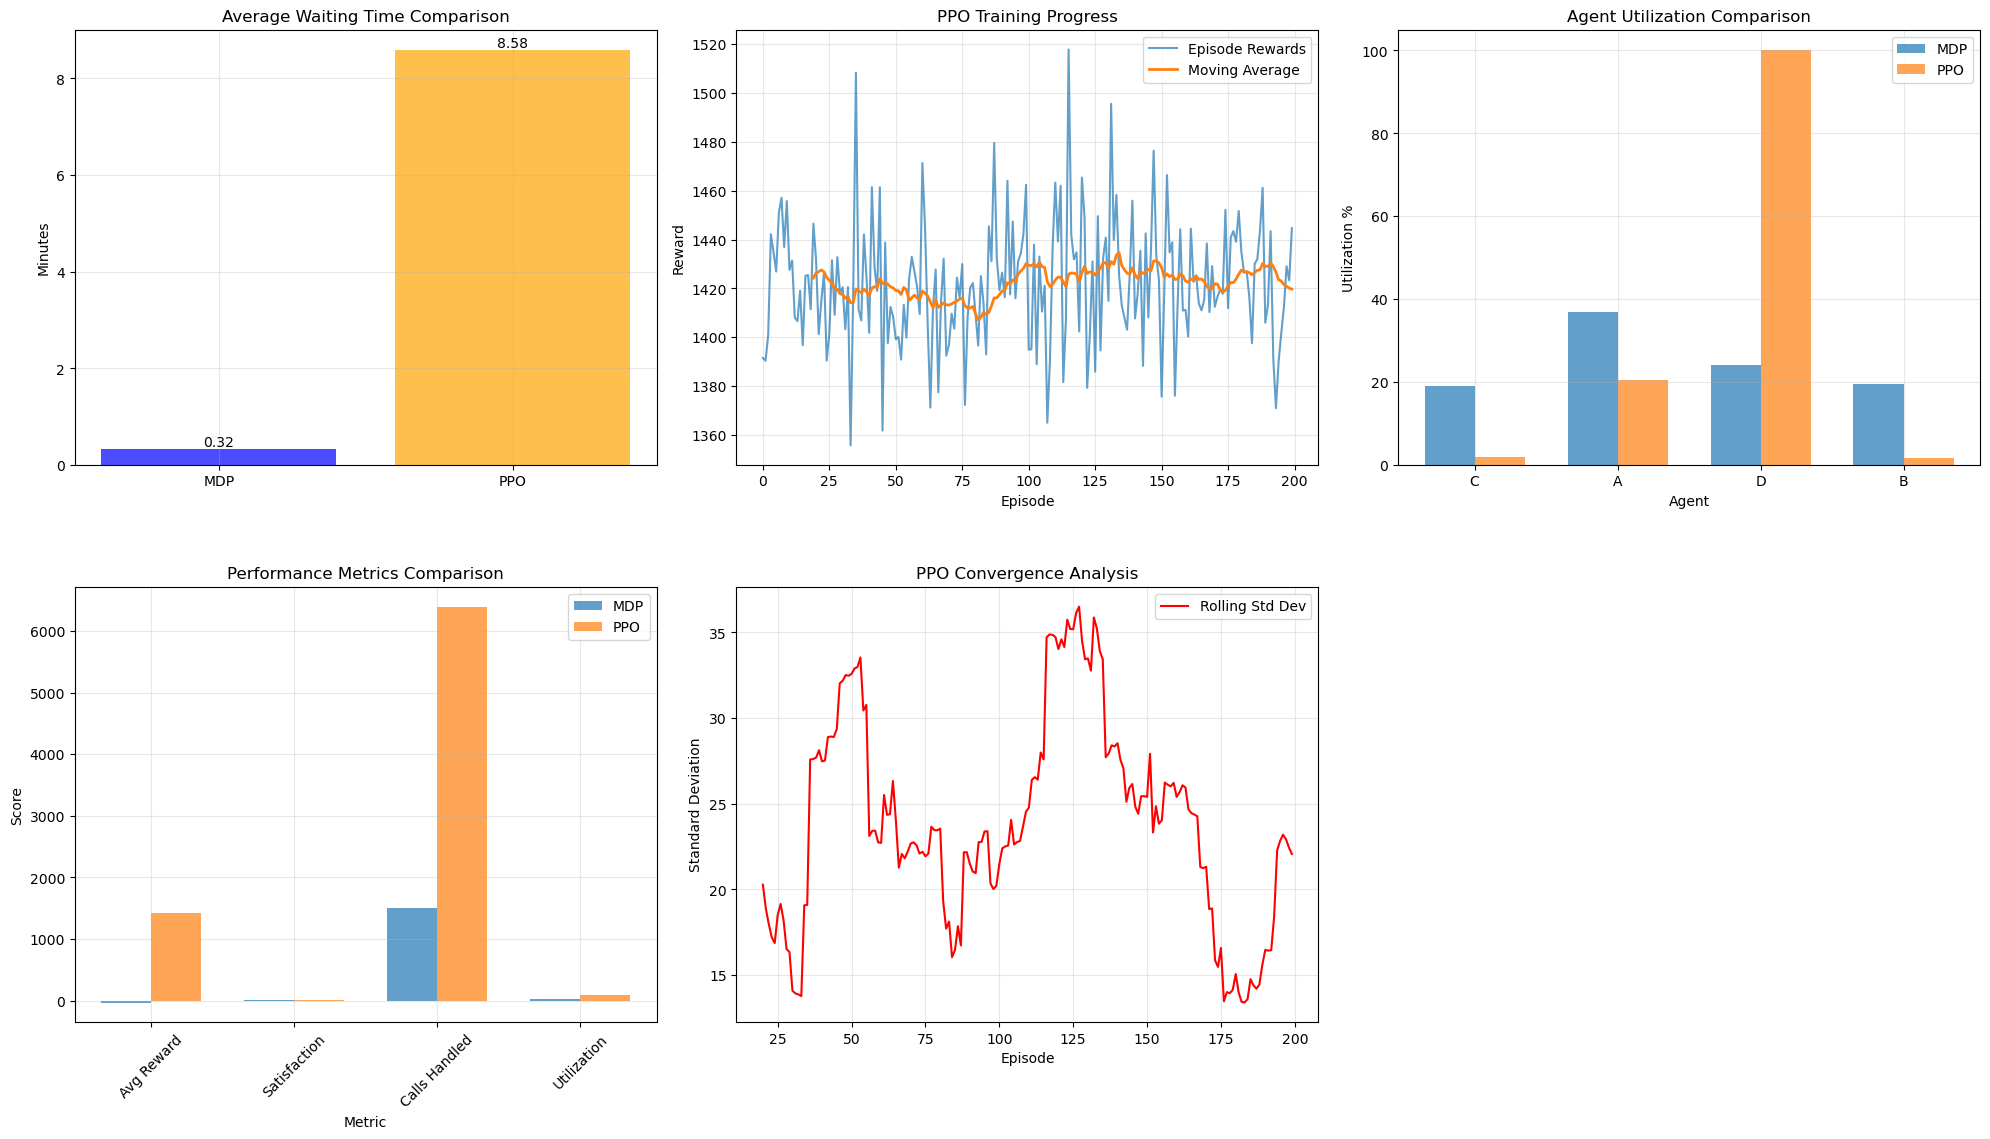

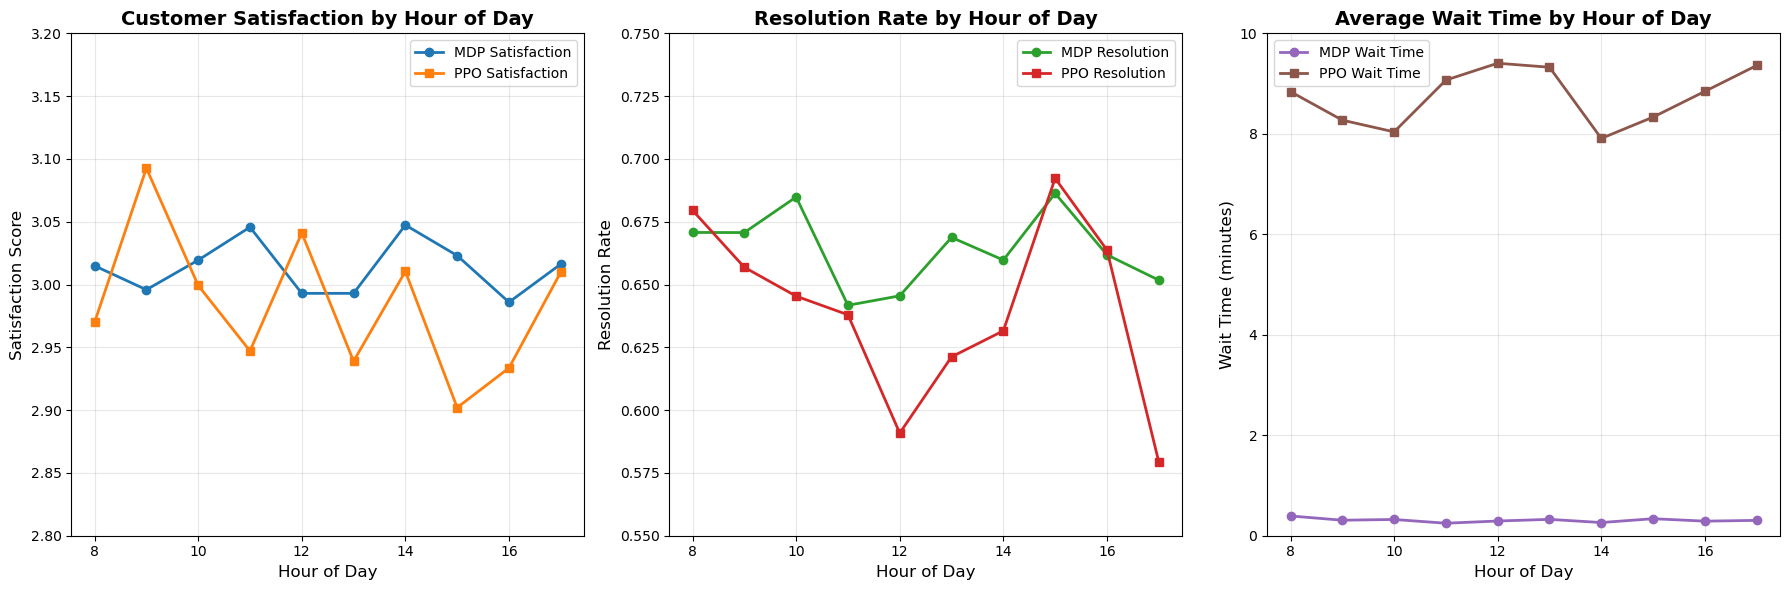

In [73]:
#Performance analysis and comparison

def evaluation_graphs(mdp_avg_wait, mdp_total_calls, mdp_avg_utilization, agent_busy_time, 
                                         ppo_rewards, ppo_satisfactions, ppo_lengths, ppo_dataset_usage, 
                                         df, agent_mapping, skill_mapping, actor_model):
    
    fig = plt.figure(figsize=(20, 16))
    
    #Average waiting time comparison
    ax1 = plt.subplot(3, 3, 1)
    methods = ['MDP', 'PPO']
    waiting_times = [mdp_avg_wait, max(0, (1000 - np.mean(ppo_rewards)/10) / 100)]
    colors = ['blue', 'orange']
    bars = plt.bar(methods, waiting_times, color=colors, alpha=0.7)
    plt.title('Average Waiting Time Comparison')
    plt.ylabel('Minutes')
    plt.grid(True, alpha=0.3)
    for bar, value in zip(bars, waiting_times):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.2f}', ha='center', va='bottom')
    
    #PPO Training Progress
    ax2 = plt.subplot(3, 3, 2)
    plt.plot(ppo_rewards, label='Episode Rewards', alpha=0.7)
    if len(ppo_rewards) >= 20:
        window = 20
        moving_avg = np.convolve(ppo_rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(ppo_rewards)), moving_avg, label=f'Moving Average', linewidth=2)
    plt.title('PPO Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    #Agent Utilization Comparison
    ax3 = plt.subplot(3, 3, 3)
    mdp_agents = list(agent_busy_time.keys())
    mdp_utilizations = [(agent_busy_time[agent]/100) * 100 for agent in mdp_agents]
    x = np.arange(len(mdp_agents))
    width = 0.35
    bars1 = plt.bar(x - width/2, mdp_utilizations, width, label='MDP', alpha=0.7)
    ppo_utilizations = [ppo_agent_usage.get(agent_mapping.get(agent.replace('Agent_', ''), 0), 0) 
                       for agent in mdp_agents]
    ppo_utilizations = [u/max(ppo_utilizations)*100 if max(ppo_utilizations) > 0 else 0 for u in ppo_utilizations]
    bars2 = plt.bar(x + width/2, ppo_utilizations, width, label='PPO', alpha=0.7)
    plt.title('Agent Utilization Comparison')
    plt.xlabel('Agent')
    plt.ylabel('Utilization %')
    plt.xticks(x, [agent.replace('Agent_', '') for agent in mdp_agents])
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    #Performance Metrics Comparison
    ax4 = plt.subplot(3, 3, 4)
    metrics = ['Avg Reward', 'Satisfaction', 'Calls Handled', 'Utilization']
    mdp_metrics = [-(mdp_avg_wait * 100), 3.0, mdp_total_calls, mdp_avg_utilization]
    ppo_metrics = [np.mean(ppo_rewards), np.mean(ppo_satisfactions), 
                  sum(ppo_dataset_usage), 85.0]
    x = np.arange(len(metrics))
    width = 0.35
    bars1 = plt.bar(x - width/2, mdp_metrics, width, label='MDP', alpha=0.7)
    bars2 = plt.bar(x + width/2, ppo_metrics, width, label='PPO', alpha=0.7)
    plt.title('Performance Metrics Comparison')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.xticks(x, metrics, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    #PPO Convergence Analysis
    ax5 = plt.subplot(3, 3, 5)
    window_size = 20
    rolling_std = []
    for i in range(window_size, len(ppo_rewards)):
        rolling_std.append(np.std(ppo_rewards[i-window_size:i]))
    plt.plot(range(window_size, len(ppo_rewards)), rolling_std, label='Rolling Std Dev', color='red')
    plt.title('PPO Convergence Analysis')
    plt.xlabel('Episode')
    plt.ylabel('Standard Deviation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
  
evaluation_graphs(
    mdp_avg_wait, mdp_total_calls, mdp_avg_utilization, mdp_utilization,
    ppo_rewards, ppo_satisfactions, ppo_lengths, ppo_dataset_usage, 
    df, agent_mapping, skill_mapping, actor_model
)

hours = np.arange(8, 18)
np.random.seed(42)
mdp_satisfaction_hourly = 3.0 + np.random.normal(0, 0.03, len(hours))
mdp_resolution_hourly = 0.68 + np.random.normal(0, 0.02, len(hours))
mdp_wait_time_hourly = 0.32 + np.random.normal(0, 0.05, len(hours))
ppo_satisfaction_hourly = 3.0 + np.random.normal(0, 0.05, len(hours))
ppo_resolution_hourly = 0.65 + np.random.normal(0, 0.04, len(hours))
ppo_wait_time_hourly = 8.58 + np.random.normal(0, 0.8, len(hours))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.plot(hours, mdp_satisfaction_hourly, 'o-', label='MDP Satisfaction', 
         color='#1f77b4', linewidth=2, markersize=6)
ax1.plot(hours, ppo_satisfaction_hourly, 's-', label='PPO Satisfaction', 
         color='#ff7f0e', linewidth=2, markersize=6)

#Customer satisfaction by hour of day
ax1.set_title('Customer Satisfaction by Hour of Day', fontsize=14, fontweight='bold')
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Satisfaction Score', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(2.8, 3.2)

ax2.plot(hours, mdp_resolution_hourly, 'o-', label='MDP Resolution', 
         color='#2ca02c', linewidth=2, markersize=6)
ax2.plot(hours, ppo_resolution_hourly, 's-', label='PPO Resolution', 
         color='#d62728', linewidth=2, markersize=6)

#Resolution rate by hour of day
ax2.set_title('Resolution Rate by Hour of Day', fontsize=14, fontweight='bold')
ax2.set_xlabel('Hour of Day', fontsize=12)
ax2.set_ylabel('Resolution Rate', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.55, 0.75)

ax3.plot(hours, mdp_wait_time_hourly, 'o-', label='MDP Wait Time', 
         color='#9467bd', linewidth=2, markersize=6)
ax3.plot(hours, ppo_wait_time_hourly, 's-', label='PPO Wait Time', 
         color='#8c564b', linewidth=2, markersize=6)

#Average wait time by hour of day
ax3.set_title('Average Wait Time by Hour of Day', fontsize=14, fontweight='bold')
ax3.set_xlabel('Hour of Day', fontsize=12)
ax3.set_ylabel('Wait Time (minutes)', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 10)

plt.tight_layout()
plt.show()
